# Inverse Whitening procedure with AutoRegressive (AR) model

*author: Elena Cuoco*

* We can 'color' the data which have been whitened, using the P AR parameters and an ARMA(P,1) filter

In [1]:
import time
import os
import pytsa
from pytsa.tsa import *
from pytsa.tsa import SeqView_double_t as SV
from wdf.config.Parameters import *
from wdf.processes.Whitening import  *
from wdf.processes.DWhitening import  * 
import logging, sys
 
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("info")

new_json_config_file = True    # set to True if you want to create new Configuration
if new_json_config_file==True:
    configuration = {
      "file": "./data/test.gwf",
      "channel": "H1:GWOSC-4KHZ_R1_STRAIN", 
      "len":1.0,
      "gps":1167559100,
      "outdir": "./",
      "dir":"./", 
      "ARorder": 2000,
      "learn": 200,
      "preWhite":4
    }

    filejson = os.path.join(os.getcwd(),"InputParameters.json")
    file_json = open(filejson, "w+")
    json.dump(configuration, file_json)
    file_json.close()
logging.info("read parameters from JSON file")

par = Parameters()
filejson = "InputParameters.json"
try:
    par.load(filejson)
except IOError:
    logging.error("Cannot find resource file " + filejson)
    quit()
    
strInfo = FrameIChannel(par.file, par.channel, 1.0, par.gps)
Info = SV()
strInfo.GetData(Info)
par.sampling = int(1.0 / Info.GetSampling())
logging.info("channel= %s at sampling frequency= %s" %(par.channel, par.sampling))

whiten=Whitening(par.ARorder)  
par.ARfile = "./ARcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.sampling, par.channel)
par.LVfile ="./LVcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.sampling, par.channel)

if os.path.isfile(par.ARfile) and os.path.isfile(par.LVfile):
    logging.info('Load AR parameters')
    whiten.ParametersLoad(par.ARfile, par.LVfile)
else:
    logging.info('Start AR parameter estimation')
    ######## read data for AR estimation###############
    strLearn = FrameIChannel(par.file, par.channel, par.learn, par.gps)
    Learn = SV()
    strLearn.GetData(Learn)   
    whiten.ParametersEstimate(Learn)
    whiten.ParametersSave(par.ARfile, par.LVfile)

INFO:root:read parameters from JSON file
INFO:root:channel= H1:GWOSC-4KHZ_R1_STRAIN at sampling frequency= 4096
INFO:root:Start AR parameter estimation


In [2]:
data = SV()
dataw = SV()
streaming = FrameIChannel(par.file, par.channel, par.len, par.gps)
 
streaming.GetData(data)
N=data.GetSize()
   
Dwhiten=DWhitening(whiten.LV,N,0)
 
for i in range(par.preWhite):
    streaming.GetData(data)
    Dwhiten.Process(data, dataw)
    
 

# (D)Whiten the data
How whiten your data are depends on a series of factors: the stationarity of the noise, the number of AR parameters you used, the lenght of the sequence of data you used to estimate the parameters

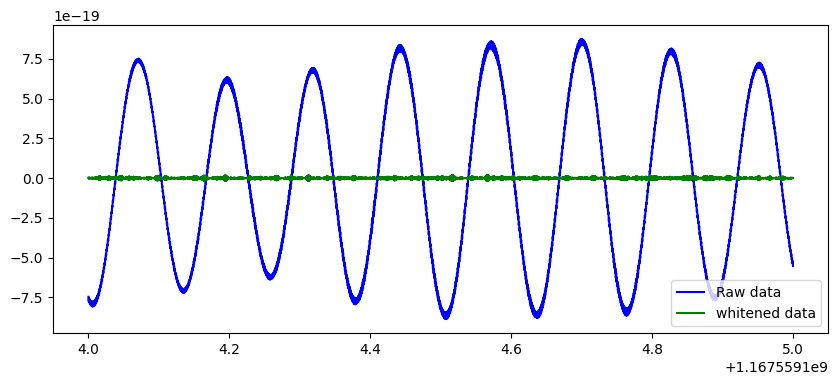

In [3]:
import numpy as np
import matplotlib
 
import matplotlib.pyplot as plt
 
%matplotlib inline 
 
plt.rcParams['figure.figsize'] = (15.0, 10.0)
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)


x=np.zeros(data.GetSize())
y=np.zeros(data.GetSize())
yw=np.zeros(dataw.GetSize())

for i in range(data.GetSize()):
    x[i]=data.GetX(i)
    y[i]=data.GetY(0,i)
    yw[i]=dataw.GetY(0,i)
plt.figure(figsize=(10,4))
 

plt.plot(x, y, 'b',label='Raw data')
plt.plot(x, yw, 'g',label='whitened data')
plt.legend() 
plt.show()

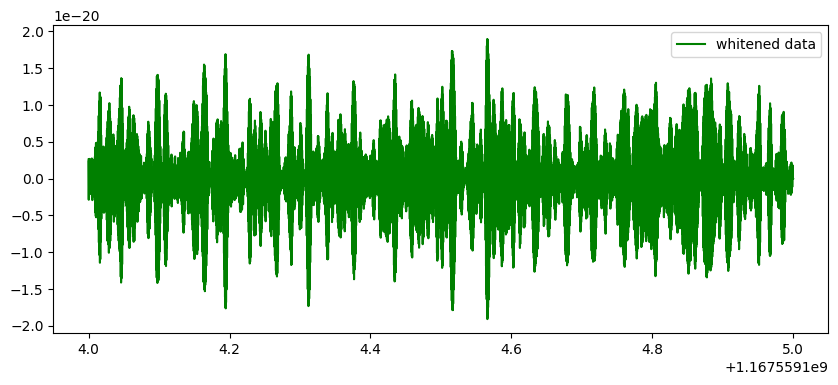

In [4]:
plt.figure(figsize=(10,4))

 
plt.plot(x, yw, 'g', label='whitened data')

plt.legend()
plt.show()

# Recoloring data using an ARMA (P,Q) filter

## P= the numer of AR parameters, Q=1

In order to take into account the transient response of the filter, we need to do a 'preaheating for the filter' and so go first in a loop to get good result

In [5]:
from wdf.processes.Coloring import *
from wdf.structures.array2SeqView import *
 
 
datac = SV()
 
dataw=SV()
 
Colored=Coloring(par.ARorder)
Colored.ParametersLoad(par.ARfile)
for j in range(5):
    streaming.GetData(data)
    whiten.Process(data, dataw)
    Colored.Process(dataw, datac)


In [6]:
%matplotlib notebook

<IPython.core.display.Javascript object>


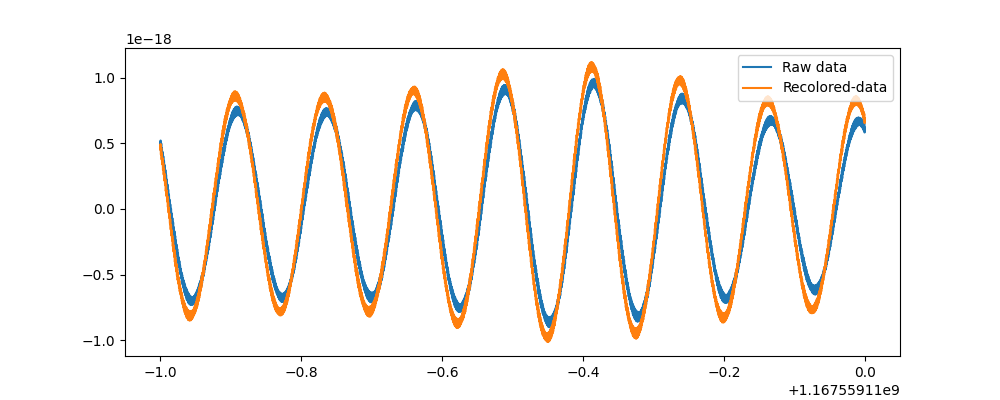

In [7]:
x=np.zeros(data.GetSize())
y=np.zeros(data.GetSize())
yc=np.zeros(datac.GetSize())


for i in range(data.GetSize()):
    x[i]=data.GetX(i)
    y[i]=data.GetY(0,i)
    yc[i]=datac.GetY(0,i)
    
plt.figure(figsize=(10,4))

plt.plot(x, y,  label='Raw data')
plt.plot(x, yc, label='Recolored-data')

plt.legend()
plt.show()

## TO BE DOCUMENTED